# Flight Price Prediction

In this notebook, we will consider the problem of modelling flight price predicition based on the data from Kaggle website.

## Import Necessary Libraries

First, we need to import the libraries that will be used throughout this notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate



## Load Datasets

Now, let's load the datasets that we will be using for our analysis.


In [8]:
# Load datasets
business_df = pd.read_csv('../datasets/business.csv')
economy_df = pd.read_csv('../datasets/economy.csv')
clean_dataset = pd.read_csv('../datasets/Clean_Dataset.csv')
business_df.head()
economy_df.head()
clean_dataset.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [14]:
#加距离数据
import pandas as pd
import numpy as np

# 创建字典，包含城市信息
locations = {
    'Delhi': (28.7041, 77.1025),
    'Mumbai': (19.0760, 72.8777),
    'Bangalore': (12.9716, 77.5946),
    'Hyderabad': (17.3850, 78.4867),
    'Kolkata': (22.5726, 88.3639),
    'Chennai': (13.0827, 80.2707)
}


# 查找DataFrame中唯一的城市名称
source_cities = set(df['source_city'].unique())
destination_cities = set(df['destination_city'].unique())
all_cities = source_cities.union(destination_cities)

# 查找locations字典中缺失的城市
missing_cities = [city for city in all_cities if city not in locations]
print("缺失的城市:", missing_cities)

def haversine(lat1, lon1, lat2, lon2):
    # 将角度转换为弧度
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # 计算经纬度差
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # 应用哈弗赛公式
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    # 地球半径大约为6371公里
    km = 6371 * c
    return km

# 读取DataFrame
clean_dataset = pd.read_csv('../datasets/Clean_Dataset.csv')

# 计算每行的距离并添加到新列
clean_dataset['distance'] = clean_dataset.apply(lambda row: haversine(locations[row['source_city']][0],
                                                locations[row['source_city']][1],
                                                locations[row['destination_city']][0],
                                                locations[row['destination_city']][1]), axis=1)

# 查看更新后的DataFrame
clean_dataset.head()

缺失的城市: []


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,distance
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,1153.241291
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,1153.241291
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,1153.241291
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,1153.241291
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,1153.241291


In [16]:
clean_dataset.shape
clean_dataset.describe(include='all')

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,distance
count,300153.000000,300153,300153,300153,300153,300153,300153,300153,300153,300153.000000,300153.000000,300153.000000,300153.000000
unique,NaN,6,1561,6,6,3,6,6,2,NaN,NaN,NaN,NaN
top,NaN,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN,NaN
freq,NaN,127859,3235,61343,71146,250863,91538,59097,206666,NaN,NaN,NaN,NaN
mean,150076.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.221021,26.004751,20889.660523,1176.732196
std,86646.852011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.191997,13.561004,22697.767366,442.080704
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,1.000000,1105.000000,290.172025
25%,75038.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830000,15.000000,4783.000000,845.318386
50%,150076.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.250000,26.000000,7425.000000,1181.882100
75%,225114.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.170000,38.000000,42521.000000,1560.696623


In [17]:
clean_dataset.dropna(inplace=True)
clean_dataset.shape


(300153, 13)

In [18]:
clean_dataset.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
distance            0
dtype: int64


# Let's visualize the first few rows of the dataset

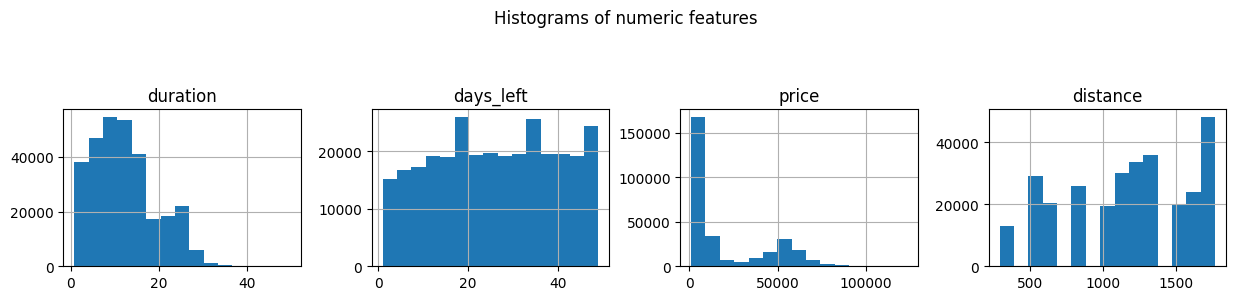

In [19]:
# Plotting histograms for all numeric features to understand distributions
# exclude the unnamed column
clean_dataset.drop('Unnamed: 0', axis=1, inplace=True)
clean_dataset.hist(bins=15, figsize=(15, 10), layout=(4, 4))
plt.suptitle('Histograms of numeric features')
plt.show()

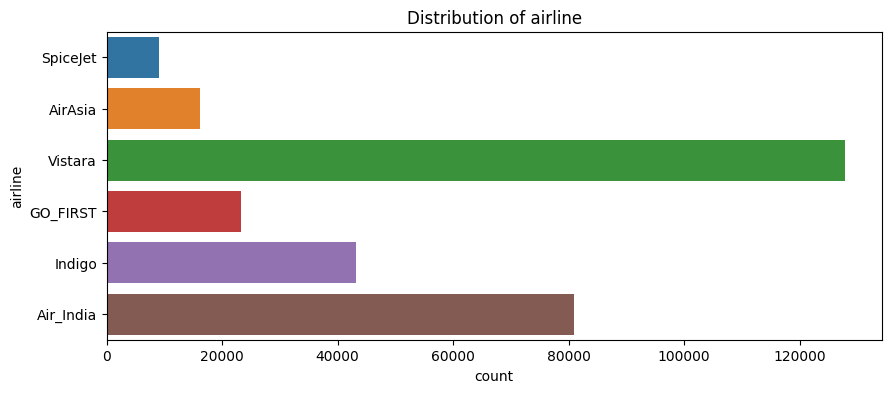

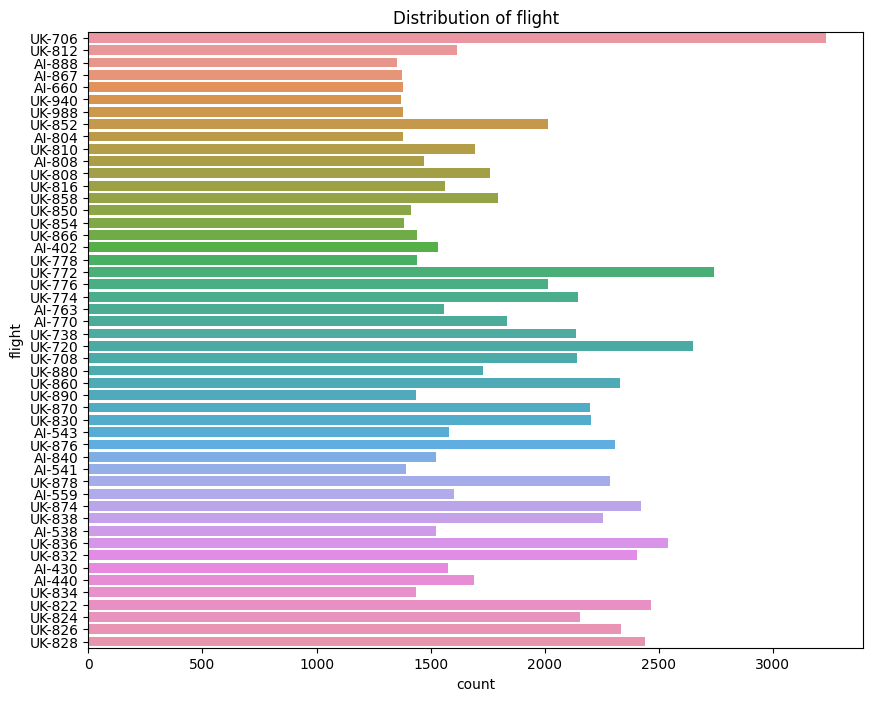

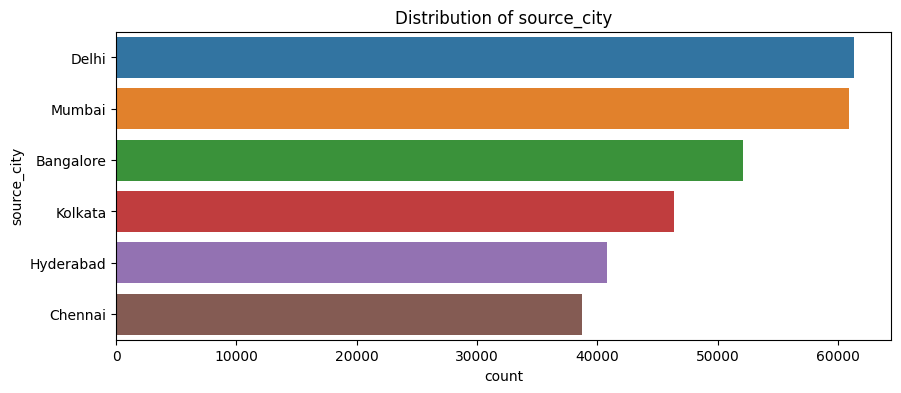

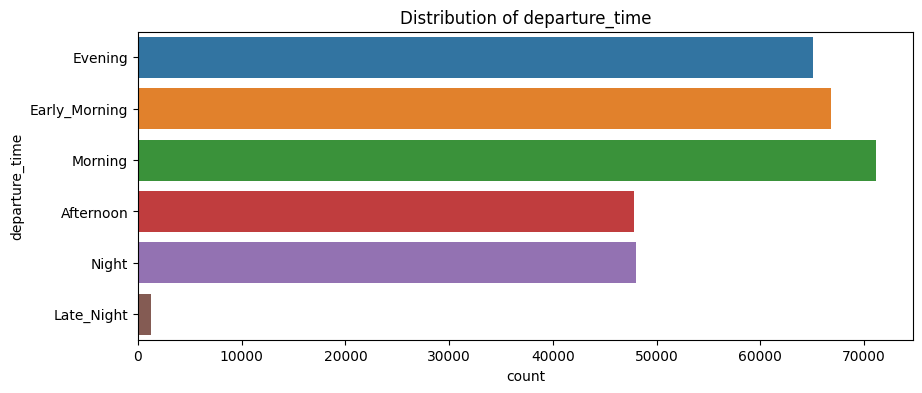

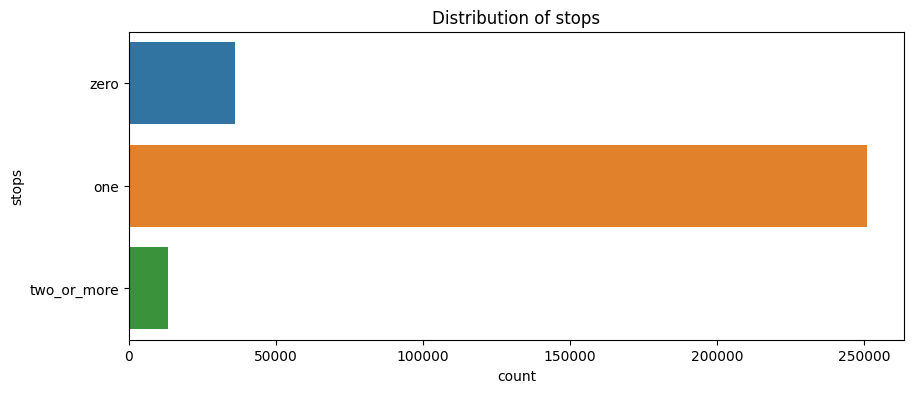

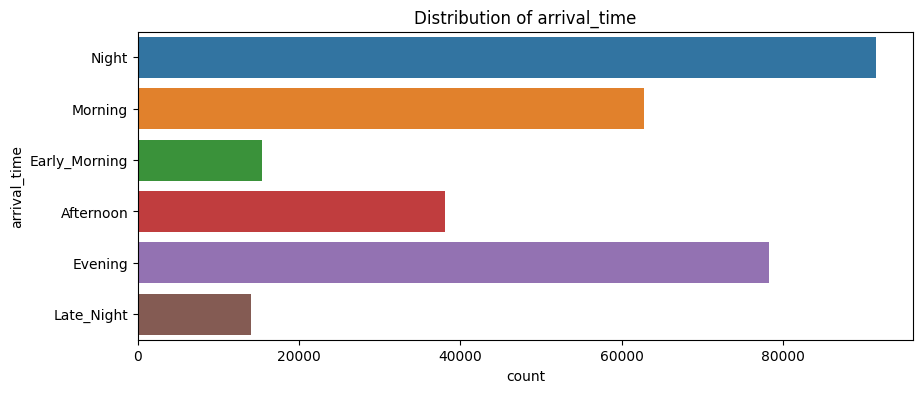

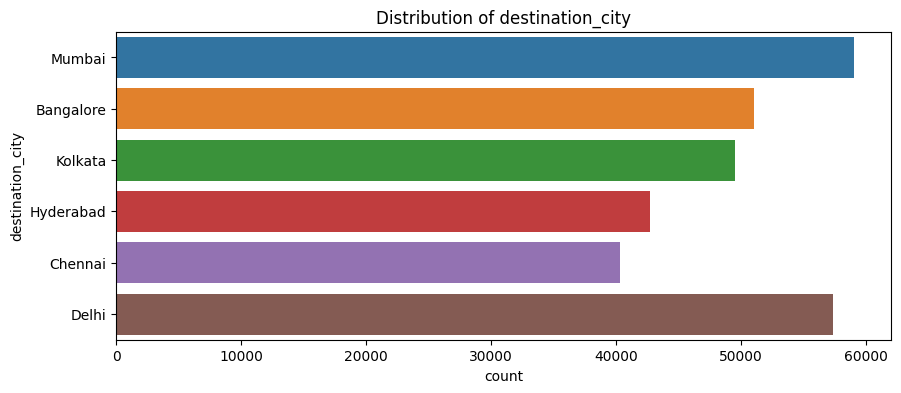

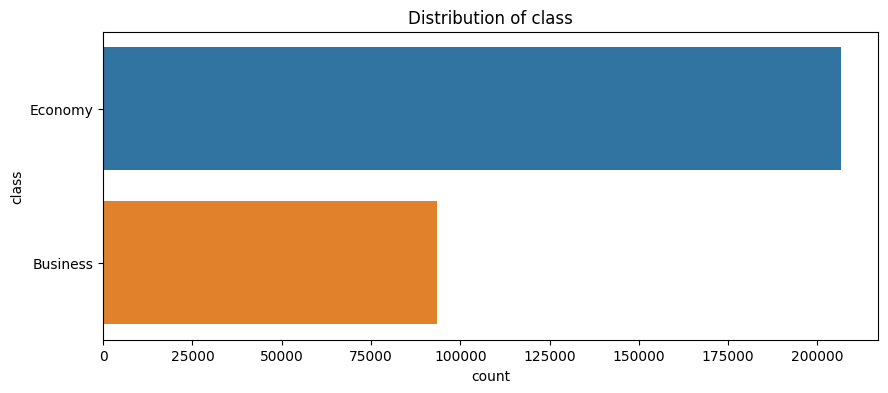

In [20]:
# For categorical data, we can use count plots to understand the distribution of categories
for column in clean_dataset.select_dtypes(include=['object']).columns:
    # Plotting count plots for all categorical features
    # If the number of categories is too high,e.g., flight, we can filter the top 50 categories to make the plot more readable
    if column != 'flight':
        plt.figure(figsize=(10, 4))
        sns.countplot(y=column, data=clean_dataset)
        plt.title(f'Distribution of {column}')
        plt.show()
    else:
        top_categories = clean_dataset[column].value_counts().index[:50]  # Get top 50 categories
        filtered_data = clean_dataset[clean_dataset[column].isin(top_categories)]
        plt.figure(figsize=(10, 8))  
        sns.countplot(y=column, data=filtered_data)
        plt.yticks(fontsize=10)
        plt.title(f'Distribution of {column}')
        plt.show()
        

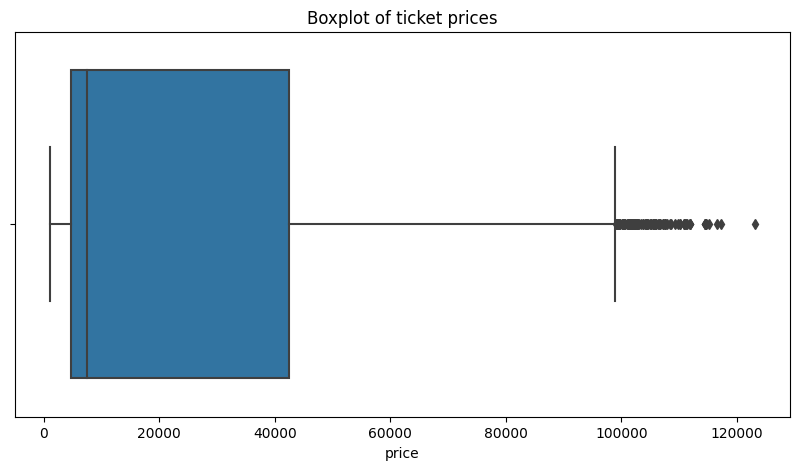

In [21]:
# Boxplot for the price column to see its distribution and spot any outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=clean_dataset['price'])
plt.title('Boxplot of ticket prices')
plt.show()

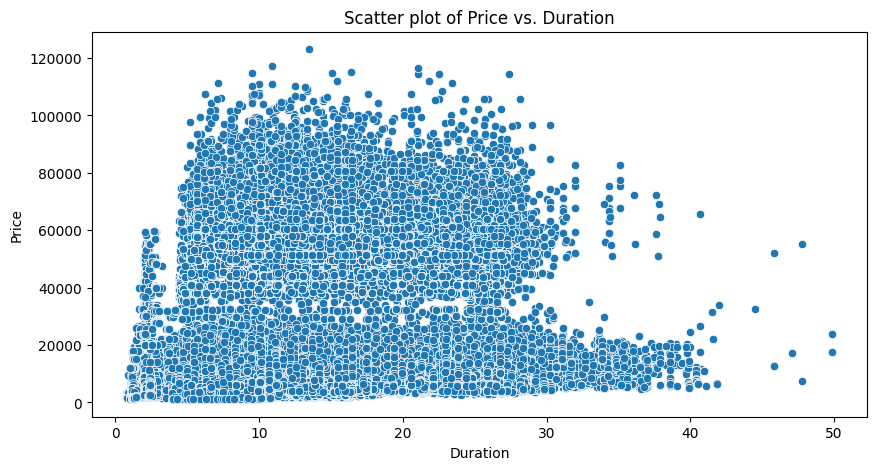

In [22]:
# A scatter plot to visualize the relationship between two variables, for example, price and duration
plt.figure(figsize=(10, 5))
sns.scatterplot(x=clean_dataset['duration'], y=clean_dataset['price'])
plt.title('Scatter plot of Price vs. Duration')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.show()


In [23]:
# Correlation heatmap to understand the relationships between variables
# Select only the numeric columns for correlation
numeric_dataset = clean_dataset.select_dtypes(include=[np.number])
correlation_matrix = numeric_dataset.corr()

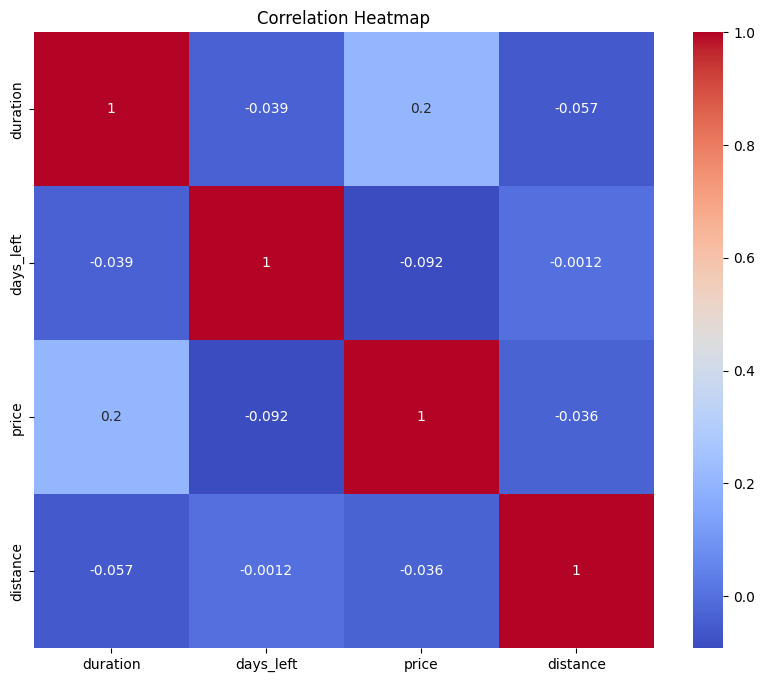

In [24]:
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

<AxesSubplot:xlabel='price'>

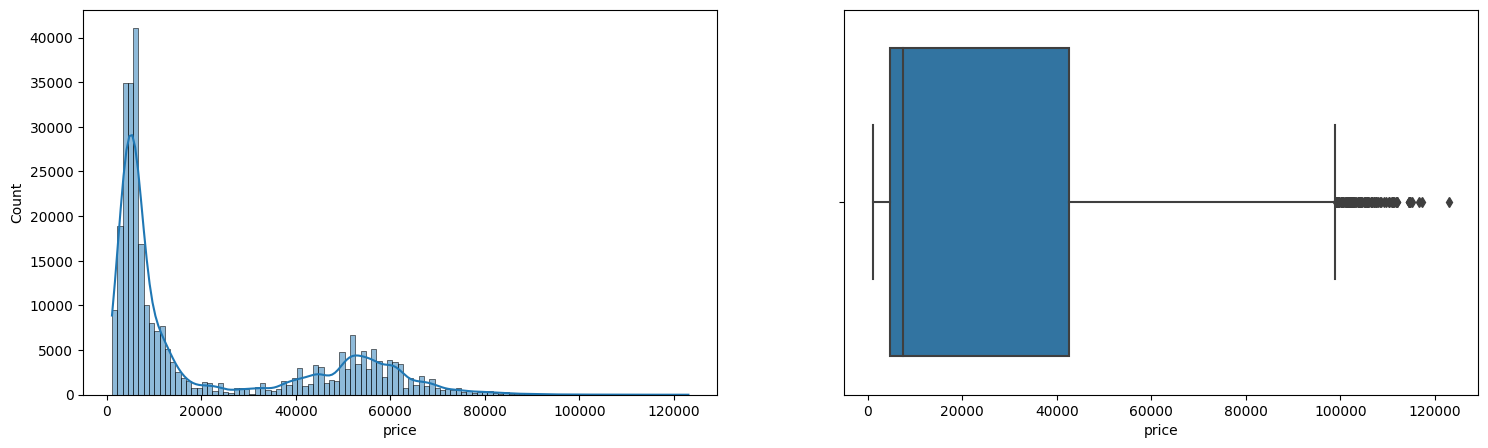

In [25]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
sns.histplot(x = 'price', data = clean_dataset, kde = True)
plt.subplot(1,2,2)
sns.boxplot(x = 'price', data = clean_dataset)

Text(0.5, 1.0, 'Airline prices based on the class and company')

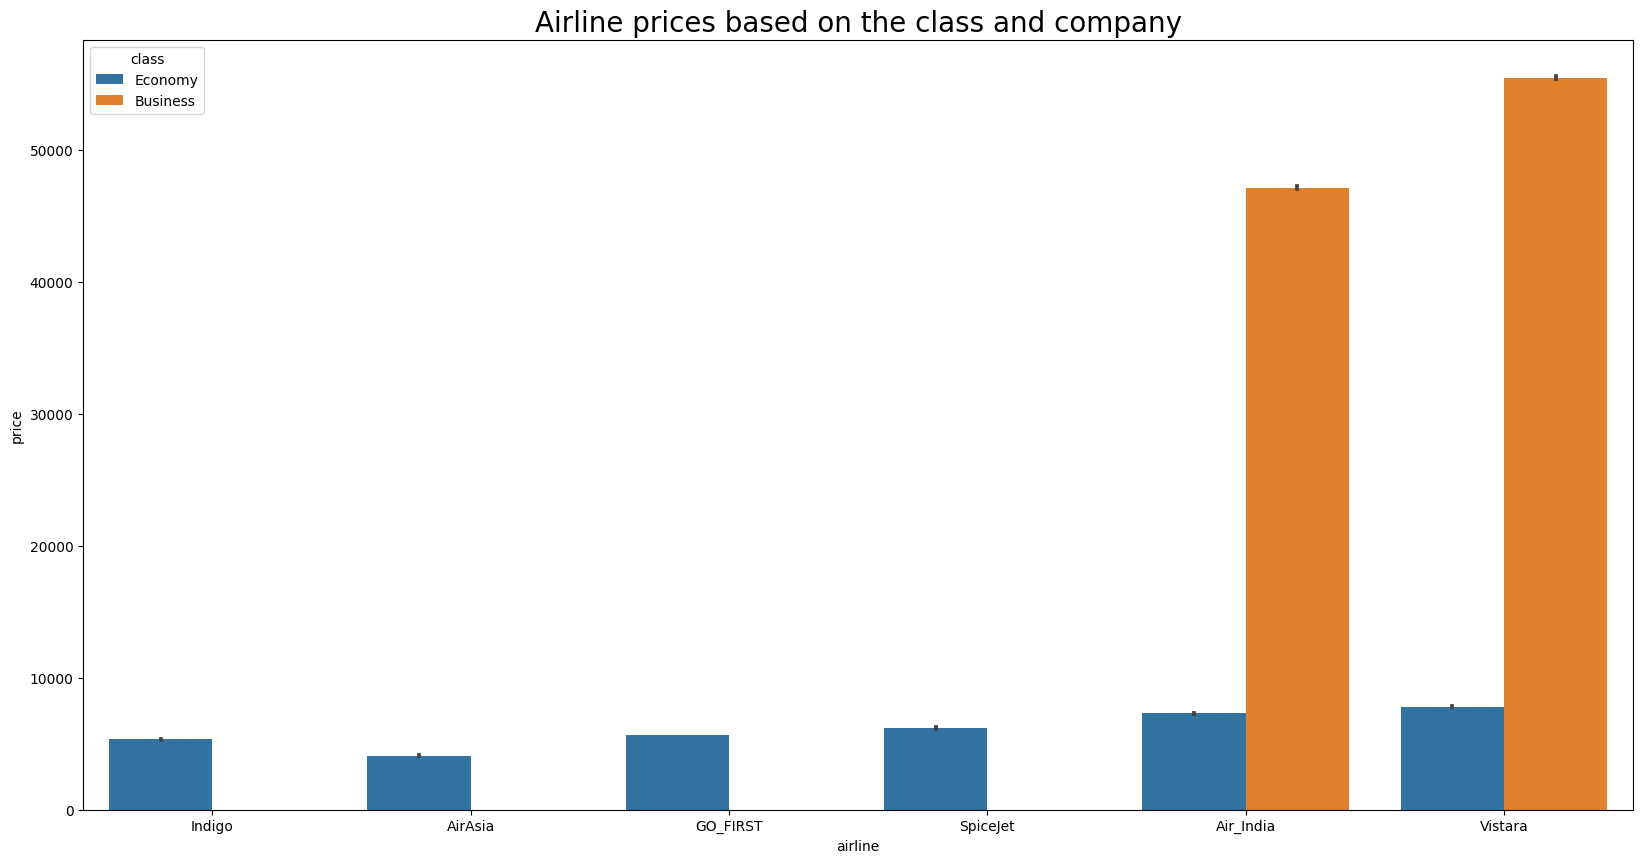

In [26]:
plt.figure(figsize=(20, 10))
sns.barplot(x='airline',y='price',hue="class",data=clean_dataset.sort_values("price")).set_title('Airline prices based on the class and company',fontsize=20)

# Make data transformation

In [27]:
transformed_dataset = clean_dataset.copy()
transformed_dataset['Economy'] = clean_dataset['class'] == 'Economy'
transformed_dataset.drop('class', axis=1, inplace=True)

In [28]:
#transformed_dataset['source_city'].unique()

In [29]:
city_size = { # this is for year 2011 - https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population
    'Delhi': 110,
    'Mumbai': 124,
    'Bangalore': 84,
    'Kolkata': 44,
    'Hyderabad': 69,
    'Chennai' : 46
}
transformed_dataset['source_size'] = transformed_dataset['source_city'].replace(city_size)
transformed_dataset.drop('source_city', axis=1, inplace=True)
transformed_dataset['destination_size'] = transformed_dataset['destination_city'].replace(city_size)
transformed_dataset.drop('destination_city', axis=1, inplace=True)

In [30]:
transformed_dataset = pd.get_dummies(transformed_dataset,columns=['departure_time','arrival_time'])

In [31]:
stops = {
    'zero': 0,
    'one': 1,
    'two_or_more': 2,
}
transformed_dataset['stops_num'] = transformed_dataset['stops'].replace(stops)
transformed_dataset.drop('stops', axis=1, inplace=True)

In [32]:
transformed_dataset = pd.get_dummies(transformed_dataset,columns=['airline'])

In [33]:
transformed_dataset['flight_num'] = pd.factorize(transformed_dataset['flight'])[0]
transformed_dataset.drop('flight', axis=1, inplace=True)

In [34]:
transformed_dataset.head()

,duration,days_left,price,distance,Economy,source_size,destination_size,departure_time_Afternoon,departure_time_Early_Morning,departure_time_Evening,...,arrival_time_Morning,arrival_time_Night,stops_num,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,flight_num
0,2.17,1,5953,1153.241291,True,110,124,0,0,1,...,0,1,0,0,0,0,0,1,0,0
1,2.33,1,5953,1153.241291,True,110,124,0,1,0,...,1,0,0,0,0,0,0,1,0,1
2,2.17,1,5956,1153.241291,True,110,124,0,1,0,...,0,0,0,1,0,0,0,0,0,2
3,2.25,1,5955,1153.241291,True,110,124,0,0,0,...,0,0,0,0,0,0,0,0,1,3
4,2.33,1,5955,1153.241291,True,110,124,0,0,0,...,1,0,0,0,0,0,0,0,1,4


In [35]:
transformed_dataset.describe()
# output the transformed dataset to a new CSV file
transformed_dataset.to_csv('../datasets/Transformed_Dataset.csv', index=False)

In [42]:
#我想用马尔可夫链试试，以下是代码
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split


# 创建航线和舱位类别的组合标识列
clean_dataset['route_class'] = clean_dataset['source_city'] + '-' + clean_dataset['destination_city'] + '-' + clean_dataset['class']

# 使用KBinsDiscretizer将价格分成几个区间
n_bins = 5  
binning = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
clean_dataset['price_bin'] = binning.fit_transform(clean_dataset[['price']]).astype(int)


max_bin = clean_dataset['price_bin'].max() + 1  # 全数据集中的最大状态数

# 分割数据集为70%训练和30%测试
train_data, test_data = train_test_split(clean_dataset, test_size=0.3, random_state=42, stratify=clean_dataset['route_class'])


# 准备两个字典来存储每条航线的转移矩阵和最常见的初始价格状态
route_class_matrices = {}
route_class_common_initial_states = {}

for route_class in train_data['route_class'].unique():
    sub_df = train_data[train_data['route_class'] == route_class]
    transition_matrix = np.zeros((max_bin, max_bin))
    
    # 计算转移概率矩阵
    for i in range(len(sub_df) - 1):
        current_state = int(sub_df.iloc[i]['price_bin'])
        next_state = int(sub_df.iloc[i + 1]['price_bin'])
        transition_matrix[current_state, next_state] += 1

    # 转换计数为概率
    if transition_matrix.sum(axis=1).all():  # 确保没有除以零的情况
        transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
    
    route_class_matrices[route_class] = transition_matrix
    # 寻找每个航线最常见的初始价格状态
    most_common_initial_state = np.argmax(sub_df['price_bin'].value_counts().values)
    route_class_common_initial_states[route_class] = most_common_initial_state
    # 测试部分：评估每条航线的模型拟合度
accuracies = {}
for route_class in test_data['route_class'].unique():
    sub_df = test_data[test_data['route_class'] == route_class]
    if route_class in route_class_matrices:
        correct_predictions = 0
        total_predictions = 0
        
        for i in range(len(sub_df) - 1):
            current_state = int(sub_df.iloc[i]['price_bin'])
            next_state = int(sub_df.iloc[i + 1]['price_bin'])
            predicted_state = np.argmax(route_class_matrices[route_class][current_state])
            
            if predicted_state == next_state:
                correct_predictions += 1
            total_predictions += 1
        
        if total_predictions > 0:
            accuracies[route_class] = correct_predictions / total_predictions

# 输出每条航线的模型拟合度
for route_class, accuracy in accuracies.items():
    print(f"航线和舱位 {route_class} 的模型拟合度: {accuracy:.2f}")

航线和舱位 Kolkata-Chennai-Business 的模型拟合度: 0.94
航线和舱位 Kolkata-Mumbai-Business 的模型拟合度: 0.81
航线和舱位 Delhi-Mumbai-Economy 的模型拟合度: 1.00
航线和舱位 Mumbai-Bangalore-Business 的模型拟合度: 0.75
航线和舱位 Mumbai-Bangalore-Economy 的模型拟合度: 1.00
航线和舱位 Mumbai-Delhi-Business 的模型拟合度: 0.50
航线和舱位 Delhi-Bangalore-Economy 的模型拟合度: 1.00
航线和舱位 Kolkata-Bangalore-Economy 的模型拟合度: 1.00
航线和舱位 Bangalore-Mumbai-Economy 的模型拟合度: 1.00
航线和舱位 Mumbai-Hyderabad-Economy 的模型拟合度: 1.00
航线和舱位 Hyderabad-Bangalore-Business 的模型拟合度: 0.59
航线和舱位 Chennai-Delhi-Business 的模型拟合度: 0.58
航线和舱位 Hyderabad-Delhi-Economy 的模型拟合度: 1.00
航线和舱位 Bangalore-Hyderabad-Economy 的模型拟合度: 1.00
航线和舱位 Hyderabad-Chennai-Business 的模型拟合度: 0.59
航线和舱位 Delhi-Kolkata-Economy 的模型拟合度: 1.00
航线和舱位 Bangalore-Kolkata-Economy 的模型拟合度: 1.00
航线和舱位 Hyderabad-Chennai-Economy 的模型拟合度: 1.00
航线和舱位 Mumbai-Kolkata-Economy 的模型拟合度: 1.00
航线和舱位 Chennai-Mumbai-Business 的模型拟合度: 0.43
航线和舱位 Delhi-Chennai-Economy 的模型拟合度: 1.00
航线和舱位 Mumbai-Chennai-Business 的模型拟合度: 0.47
航线和舱位 Bangalore-Delhi-Economy 的模型拟合度: 1.0

In [44]:

# 获取价格区间的边界
bin_edges = binning.bin_edges_[0]

# 输出价格预测
for route_class, matrix in route_class_matrices.items():
    initial_state = route_class_common_initial_states[route_class]
    likely_next_state = np.argmax(matrix[initial_state])
    initial_price_range = f"{bin_edges[initial_state]:.2f} to {bin_edges[initial_state + 1]:.2f}"
    next_price_range = f"{bin_edges[likely_next_state]:.2f} to {bin_edges[likely_next_state + 1]:.2f}"
    print(f"航线和舱位 {route_class}:")
    print(f"  最常见的初始价格状态: {initial_state} ({initial_price_range})")
    print(f"  预测的下一个最可能的价格状态: {likely_next_state} ({next_price_range})")
    print()


航线和舱位 Bangalore-Delhi-Economy:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 0 (1105.00 to 25498.20)

航线和舱位 Hyderabad-Bangalore-Business:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 2 (49891.40 to 74284.60)

航线和舱位 Chennai-Mumbai-Economy:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 0 (1105.00 to 25498.20)

航线和舱位 Mumbai-Kolkata-Business:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 0 (1105.00 to 25498.20)

航线和舱位 Bangalore-Mumbai-Economy:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 0 (1105.00 to 25498.20)

航线和舱位 Hyderabad-Mumbai-Business:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 2 (49891.40 to 74284.60)

航线和舱位 Kolkata-Bangalore-Economy:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 0 (1105.00 to 25498.20)

航线和舱位 Chennai-Hyderabad-Business:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 1 (25498.20 to 49891.40)

航线和舱位 Mumbai-Hyderabad-Economy:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 0